# Analysis of Data

## Import libraries and data

In [1]:
import pandas as pd
import geopandas as gpd
from collections import Counter
import re

In [2]:
rich_data = pd.read_pickle("data/unique_aligned_tagged.pkl")
#convert to geopandas dataframe
rich_data = gpd.GeoDataFrame(rich_data, geometry=rich_data.geometry)

## Add column with binned year data

In [82]:
#binning data: e.g. 1860-1869 -> 1860 (1860s, but in order to keep it an integer, the "s" is ommitted)
rich_data["annee_bin"] = pd.cut(rich_data["annee"], right=False,
                bins=[1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930],
                labels=[1839, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920])

<AxesSubplot:>

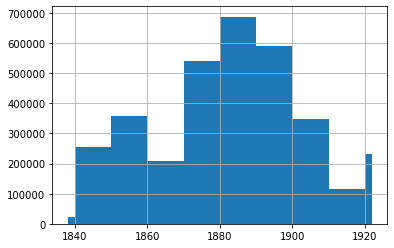

In [83]:
rich_data["annee_bin"].hist(bins=[1838, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1922])

## First Analysis on Professions

In [3]:
# make profession tags usable

def get_prof_list(entry):
    entry = str(entry)
    return re.findall("'([a-zA-ZÀ-ÿ]+)'", entry)

def get_prof_str(entry):
    return ", ".join(get_prof_list(entry))

rich_data["tags"] = rich_data["tags"].apply(get_prof_str)

In [6]:
rich_data["tags"].head(1)

12    ore, député
Name: tags, dtype: object

In [7]:
# first look into profession data
print(Counter(rich_data["metier"]).most_common(10))
print(Counter(rich_data["tags"]).most_common(10))

[('vins', 219908), ('épicier', 90578), ('médecin', 53125), ('coiffeur', 48039), ('propriétaire', 46985), ('tailleur', 45777), ('boulanger', 43090), ('boucher', 42356), ('architecte', 34484), ('peintre-artiste', 27821)]
[('vins', 220869), ('épicier', 92042), ('propriétaire', 70277), ('médecin', 55488), ('coiffeur', 48624), ('tailleur', 47490), ('boulanger', 43935), ('boucher', 42757), ('architecte', 36165), ('artiste, peintre', 33380)]


In [8]:
# get only jobs with frequency in dataset higher than 50
freq_jobs = [metier for metier, count in Counter(rich_data["tags"]).items() if count>50]
print("number of frequent jobs:", len(freq_jobs))

number of frequent jobs: 3927


In [11]:
# see how many rows include frequent jobs
print("all rows:", len(rich_data))
freq_job_data = rich_data[rich_data["tags"].isin(freq_jobs)]
print("only rows with frequent jobs:", len(freq_job_data))

all rows: 3359249
only rows with frequent jobs: 2851788


<AxesSubplot:xlabel='annee'>

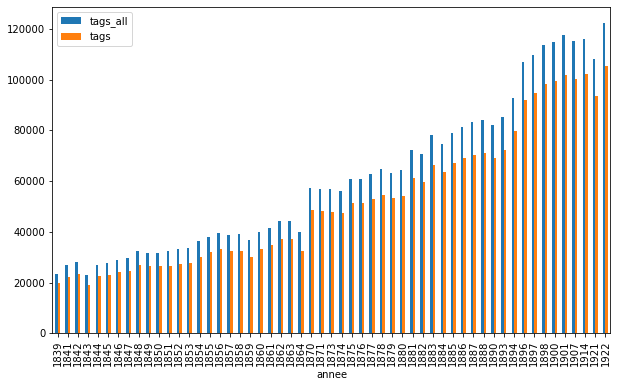

In [12]:
count_year = rich_data.groupby(by="annee").count()[["tags"]]
count_year_freq = freq_job_data.groupby(by="annee").count()[["tags"]]
both_freq = count_year.join(count_year_freq, lsuffix="_all")

# this plot shows that the omitting of jobs with frequency <50 is affecting all years evenly
both_freq.plot.bar(y=["tags_all", "tags"], figsize=(10,6))

In [195]:
def plot_ratio_over_time(df, top_names, col_name="tags", title=""):
    '''
    Computes the ratio top_names/all for each year in the dataframe and each name in top_names
    and stores them in a new df.

    Parameters:
    ----------------
    df: dataframe with relevant data
    '''
    #get list of all years in dataframe
    all_years = sorted(df["annee"].unique())
    #instantiate empty dataframe
    df_top_jobs = pd.DataFrame(columns=top_names, index=all_years)
    for year in all_years:
        year_data = df[df["annee"]==year]
        len_year = len(year_data)
        # get ratio for all jobs
        for top_job in top_names:
            job_ratio = len(year_data[year_data[col_name]==top_job])/len_year
            df_top_jobs.loc[year, top_job] = job_ratio   
    ax = df_top_jobs.plot.line(figsize=(10,6), title=title)
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    return ax.plot()  

[]

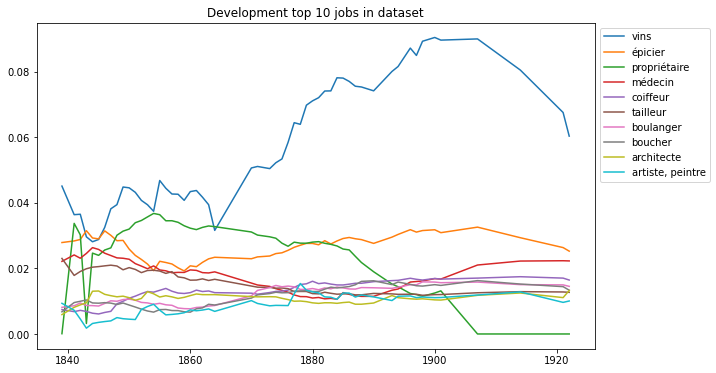

In [202]:
#get ratio of top 10 jobs in dataset
top_jobs10 = Counter(freq_job_data["tags"]).most_common(10)
top_jobnames10 = [name for name, count in top_jobs10]
plot_ratio_over_time(rich_data, top_jobnames10, title="Development top 10 jobs in dataset")

[]

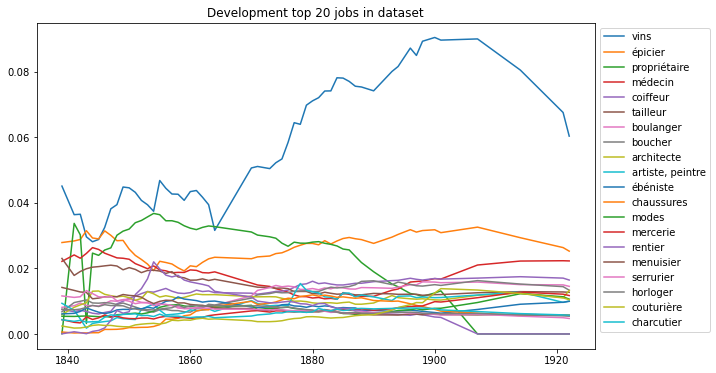

In [203]:
#get ratio of 20 top jobs in dataset
top_jobs20 = Counter(freq_job_data["tags"]).most_common(20)
top_jobnames20 = [name for name, count in top_jobs20]
plot_ratio_over_time(rich_data, top_jobnames20, title="Development top 20 jobs in dataset")

## Street statistics

[]

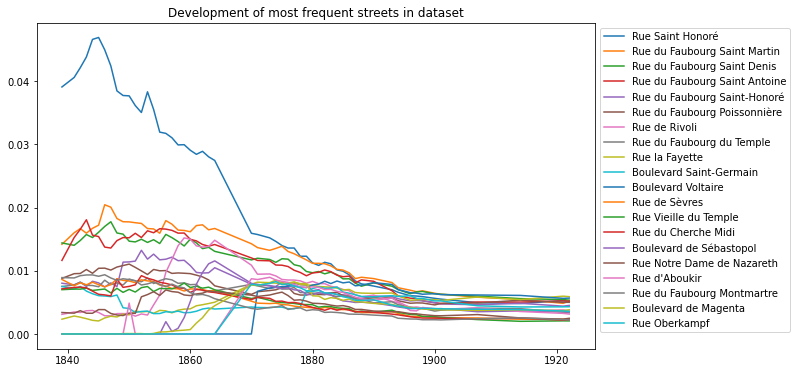

In [201]:
#can use the jobcode also to plot most frequent streets
top_streets20 = Counter(rich_data["streetname"]).most_common(20)
top_streets20 = [name for name, count in top_streets20]

plot_ratio_over_time(rich_data, top_streets20, col_name="streetname",
        title="Development of most frequent streets in dataset")

### Looking at one street

[]

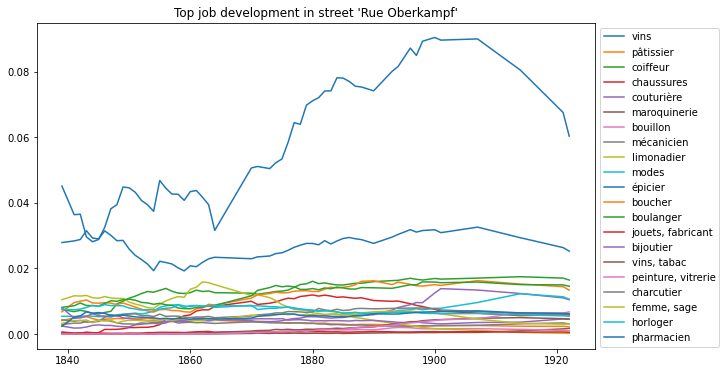

In [199]:
def get_jobs_overtime(df, streetname, int_top_per_decade=10):
    selected = rich_data[rich_data["streetname"]==streetname]
    selected_decades = sorted(selected["annee_bin"].unique())

    selected_jobs = []
    for decade in selected_decades:
        selected_dec_data = selected[selected["annee_bin"]==decade]
        top_dec_jobs = Counter(selected_dec_data["tags"]).most_common(int_top_per_decade)
        top_dec_jobs = [name for name, count in top_dec_jobs]
        selected_jobs += top_dec_jobs
    # delete duplicates
    return list(set(selected_jobs))

oberkampf_jobs = get_jobs_overtime(rich_data, "Rue Oberkampf")
plot_ratio_over_time(rich_data, oberkampf_jobs, title="Top job development in street 'Rue Oberkampf'")

[]

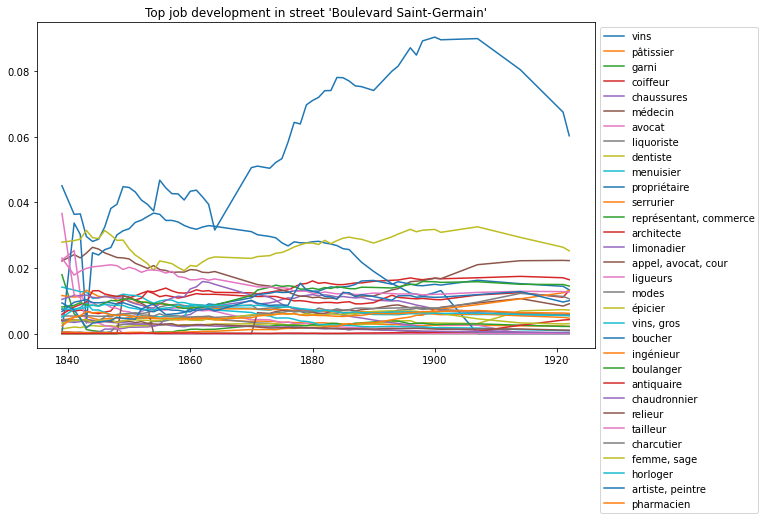

In [200]:
stgermain_jobs = get_jobs_overtime(rich_data, "Boulevard Saint-Germain")
plot_ratio_over_time(rich_data, stgermain_jobs, title="Top job development in street 'Boulevard Saint-Germain'")

### Most changing jobs

In [124]:
#safe number of bottin entries per year in a dict {year: #entries}
count_per_year = rich_data.groupby("annee").count()
count_per_year = dict(zip(count_per_year.index, count_per_year["row"]))
#count_per_year

In [174]:
df = rich_data.groupby(["tags", "annee"]).count()[["row"]]
df["job_ratio_by_year"] = df.apply(lambda x: x.row/count_per_year[x.name[1]], axis=1)
df


row  job_ratio_by_year
tags                         annee                        
                             1839    92           0.003910
                             1841    42           0.001572
                             1842    27           0.000958
                             1843    32           0.001384
                             1844    41           0.001527
...                                 ...                ...
îles, bois, tranchage        1922     2           0.000016
îles, noyer, bois, placage   1853     1           0.000030
óculenger                    1898     1           0.000009
ópicior                      1854     1           0.000028
örfáure, bijoutier, joailler 1879     1           0.000016

[589502 rows x 2 columns]

In [205]:
df_ratio = df[["job_ratio_by_year"]].groupby("tags").std().dropna().sort_values(by="job_ratio_by_year", ascending=False)
std_list = list(df_ratio.reset_index().head(20)["tags"])

[]

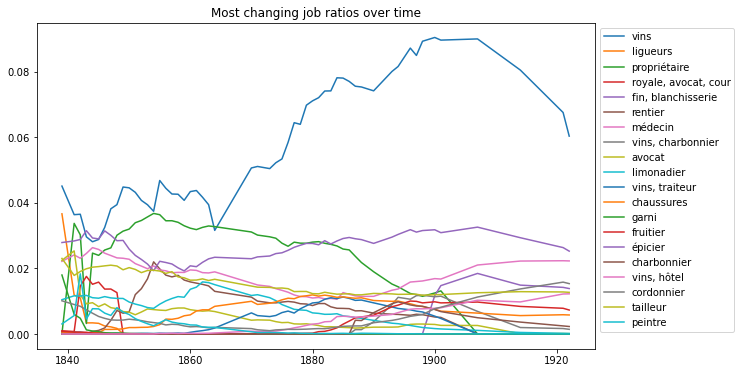

In [206]:
plot_ratio_over_time(rich_data, std_list, title="Most changing job ratios over time")

### Looking at certain jobs

<AxesSubplot:xlabel='annee'>

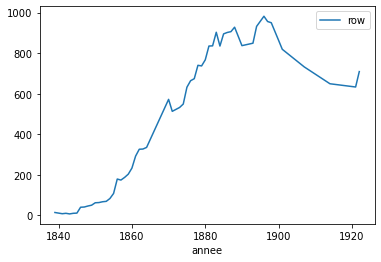

In [209]:
chaussures = rich_data[rich_data["tags"]=="chaussures"]
chaussures.groupby("annee").count()[["row"]].plot.line()

<AxesSubplot:xlabel='annee'>

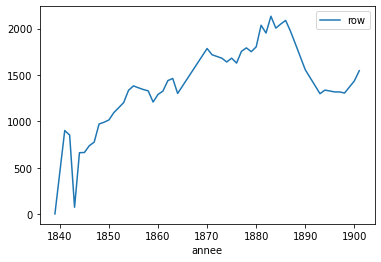

In [210]:
proprietaire = rich_data[rich_data["tags"]=="propriétaire"]
proprietaire.groupby("annee").count()[["row"]].plot.line()

# Professions which were born or died out

In [244]:
def jobs_not_before_after_specific_year(df, year, job_col="tags"):
    '''
    Splits dataset in before and after given year, then checks for jobs which are only in one of the
    two sets.
    '''
    df = freq_job_data.groupby(["annee", job_col]).count().reset_index()
    df["afterYearX"] = df.apply(lambda x: x.annee>year, axis=1)
    grouped_df = df.groupby(["afterYearX", job_col]).count().reset_index()    
    
    after = grouped_df[grouped_df["afterYearX"]]
    before = grouped_df[~grouped_df["afterYearX"]]

    jobs_after = set(after[job_col])
    jobs_before = set(before[job_col])

    not_before_yearX = jobs_after.difference(jobs_before)
    not_after_yearX = jobs_before.difference(jobs_after)

    return not_after_yearX, not_before_yearX

def sort_by_number_of_words(set_data):
    '''
    Takes profession strings, checks how many words are contained in them and returns them sorted by
    the number of words (one, two or more words)
    '''
    list_data = list(set_data)
    one_word = []
    two_words = []
    more_words = []
    for entry in list_data:
        entry_list = entry.split(", ")
        if len(entry_list) == 1:
            one_word += entry_list
        elif len(entry_list) == 2:
            two_words.append(", ".join(entry_list))
        else:
            more_words.append(", ".join(entry_list))
    
    return one_word, two_words, more_words

In [248]:
not_after1880, not_before1880 = jobs_not_before_after_specific_year(freq_job_data, 1880)

not_bef1880_one, _, _ = sort_by_number_of_words(not_before1880)
not_aft1880_one, _, _ = sort_by_number_of_words(not_after1880)
print("new profession entries - only after 1880 (one word entries):\n", not_bef1880_one, 
        "\n\nold profession entries - only before 1880 (one word entries):\n", not_aft1880_one)


new profession entries - only after 1880 (one word entries):
 ['poissonnerie', 'brocanteuse', 'importateurs', 'garage', 'masseuse', 'masseur', 'cannage', 'électriciens', 'massage', 'outillage', 'stoppeuse', 'triperie', 'reconnaissances', 'automobiles', 'phototypie', 'bicyclettes', 'ravalements', 'postiches', 'alimentation', 'pneumatiques', 'décolleteur', 'jerseys', 'cycles', 'charbonnière', 'décolletage', 'bar'] 

old profession entries - only before 1880 (one word entries):
 ['mérinos', 'lettres', 'pair', 'prop', 'accordeur', 'garni', 'huile', 'toiseur', 'bonnets', 'pension', 'grènetier']


In [249]:
not_after1860, not_before1860 = jobs_not_before_after_specific_year(freq_job_data, 1860)

not_bef1860_one, _, _ = sort_by_number_of_words(not_before1860)
not_aft1860_one, _, _ = sort_by_number_of_words(not_after1860)
print("new profession entries - only after 1860 (one word entries):\n", not_bef1860_one, 
        "\n\nold profession entries - only before 1860 (one word entries):\n", not_aft1860_one)


new profession entries - only after 1860 (one word entries):
 ['plisseur', 'briquetier', 'vacherie', 'robinetterie', 'liquidateur', 'masseuse', 'antiquaires', 'corsetière', 'photogravure', 'charbonnages', 'outillage', 'chaisier', 'décolleteur', 'poissons', 'jerseys', 'électricité', 'cordonnerie', 'bar', 'prestidigitateur', 'brocanteuse', 'importateurs', 'sièges', 'ciments', 'gérant', 'rideaux', 'dépositaire', 'cannage', 'phonographes', 'chemiserie', 'terrassier', 'abats', 'brocanteur', 'stoppeuse', 'confections', 'expert', 'plumassières', 'bronzeurs', 'ravalements', 'fruiterie', 'brocanteurs', 'alimentation', 'pâtisserie', 'mariages', 'soldes', 'laqueur', 'manucure', 'bal', 'bazar', 'imprimerie', 'vélocipèdes', 'électriciens', 'massage', 'teinturerie', 'verreries', 'triperie', 'reconnaissances', 'matelassière', 'phototypie', 'timbrage', 'postiches', 'oculariste', 'corsages', 'cartomancienne', 'pneumatiques', 'charbonnière', 'journaux', 'poissonnerie', 'contentieux', 'expropriations', '

In [250]:
not_after1900, not_before1900 = jobs_not_before_after_specific_year(freq_job_data, 1900)

not_bef1900_one, _, _ = sort_by_number_of_words(not_before1900)
not_aft1900_one, _, _ = sort_by_number_of_words(not_after1900)
print("new profession entries - only after 1900 (one word entries):\n", not_bef1900_one, 
        "\n\nold profession entries - only before 1900 (one word entries):\n", not_aft1900_one)


new profession entries - only after 1900 (one word entries):
 ['postiches', 'cannage'] 

old profession entries - only before 1900 (one word entries):
 ['estaminet', 'pair', 'escompteur', 'lingère', 'boiseries', 'épiceries', 'employé', 'vias', 'grènetier', 'physicien', 'coffretier', 'littérateur', 'huile', 'bonnets', 'bonnetiers', 'pension', 'mérinos', 'ligueurs', 'placeur', 'roulage', 'lettres', 'prop', 'chanoine', 'accordeur', 'afficheur', 'artiste', 'lettre', 'garni', 'stéréotypeur', 'toiseur', 'autographe', 'débiteur', 'carreleur']


### Working with geodata

In [29]:
# alternative: rich_data.geometry.representative_point
rich_data["centroid"] = rich_data.geometry.centroid

In [30]:
rich_notna = rich_data.dropna()

In [31]:
horloger = rich_notna[rich_notna.metier=="horloger"]
horloger["centroid"].explore()

In [32]:
modes = rich_notna[rich_notna.metier=="modes"]
modes["centroid"].explore()